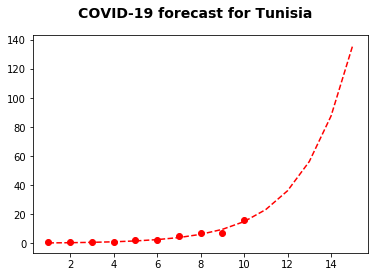

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
from scipy.optimize import curve_fit

data = pd.read_csv("../data/time_series_19-covid-Confirmed.csv")

def clean_data(dataframe, country):
    mydata = dataframe[dataframe['Country/Region'] == country].drop(columns=["Province/State", 
            "Country/Region", "Lat", "Long"]).reset_index(drop=True).T
    mydata.rename(columns={0:"cumulative_count"}, inplace=True)
    mydata["date"] = pd.to_datetime( mydata.index )
    mydata = mydata[mydata["cumulative_count"]!=0]
    mydata["days"] = np.linspace(1, len(mydata), len(mydata))
    mydata.reset_index(drop=True, inplace=True)   
    return mydata 

def SPG(t, r, m, A):
    """ """
    return (  ((r/m)*np.array(t)  ) +A )**m

def expgrowth(t, alpha, beta): 
    """ exponential growth"""
    return alpha*np.exp( np.array(t))**beta

def curve_fitting(dataframe): 
    days = dataframe.days
    cases_count = dataframe.cumulative_count
    parameters, pcov = curve_fit(expgrowth, days, cases_count)
    return parameters, pcov

def plot_exp_forecast(dataframne, popt, forecast_offset=5, color="red"): 
    plot1 = plt.plot(dataframne.days, dataframne.cumulative_count,'o'  ,color =color)
    offset_array = np.arange(list(Tunisia.days)[-1]+1, list(Tunisia.days)[-1]+forecast_offset+1  )
    offset = np.append(Tunisia.days, offset_array )
    #np.append(Tunisia.days)
    plot2 =  plt.plot(offset, expgrowth(offset, *popt),"--",color =color)
    return plot1, plot2




forecast = 5

fig = plt.figure()
fig.suptitle('COVID-19 forecast for Tunisia', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
#ax.text(1, 12, r'Forecast for {0} after the \n first  day of the outbreak', 
#        bbox={'facecolor': 'white',  'pad': 10})
popt, pcov = curve_fitting(Tunisia)
plot_exp_forecast(Tunisia, popt, 5)

plt.savefig("COVID_Tn.svg")




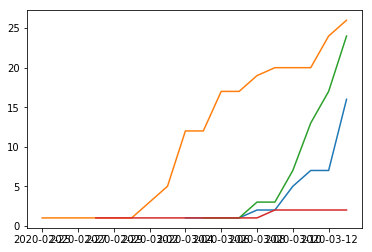

In [2]:
Italy = clean_data(data, "Italy")
Tunisia = clean_data(data, "Tunisia")
Algeria = clean_data(data, "Algeria")
SA = clean_data(data, "South Africa")
Egypt = clean_data(data, "Egypt")
Nigeria = clean_data(data, "Nigeria")
#plt.plot(Italy.date, Italy.cumulative_count )
plt.plot(Tunisia.date, Tunisia.cumulative_count )
plt.plot(Algeria.date, Algeria.cumulative_count )
plt.plot(SA.date, SA.cumulative_count)
#plt.plot(Egypt.date, Egypt.cumulative_count )
plt.plot(Nigeria.date, Nigeria.cumulative_count )



#dc584a
country: Tunisia,  alpha = 0.17949020801898066   beta = 0.4421380106414777
country: Morocco,  alpha = 0.528372279429742   beta = 0.21532015079804542
country: Algeria,  alpha = 2.561596129673487   beta = 0.1347474363130141
country: South Africa,  alpha = 0.602712287758543   beta = 0.4130547253959403


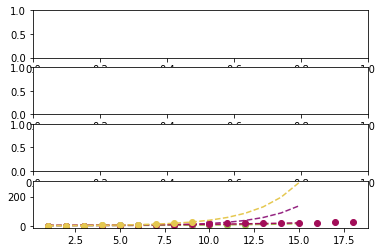

In [121]:
import random 
import matplotlib.colors as col 
import itertools

def random_col(alpha=1, keep_alpha=False):
    r = random.random()
    g = random.random()
    b = random.random()
    return col.to_hex((r, g, b, alpha), keep_alpha=keep_alpha)
print(random_col() )
    
def wrap(countries, dataframe):
    number_of_panels = len(countries)
    fig, axs = plt.subplots(number_of_panels, 1 )    
    for country in countries: 
        idx = countries.index(country)

        clean = clean_data(dataframe, country)
        popt, pcov = curve_fitting(clean)
        print("country: {0},  alpha = {1}   beta = {2}".format(country, popt[0], popt[1]) )    
        plot1, plot2 = plot_exp_forecast(clean, popt, 5, color = random_col() )
        

        
wrap(["Tunisia", "Morocco", "Algeria", "South Africa"], data)

In [81]:
2%3

2

In [119]:
countries = ["Tunisia", "Morocco", "Algeria", "South Africa"]
countries.index("Morocco")


1

In [105]:
list(range(4) )


[0, 1, 2, 3]

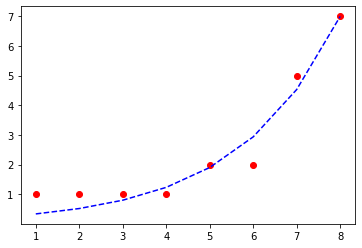

In [112]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(expgrowth, days, subpd[75])
plt.plot(days, subpd[75],'o'  ,color ="red")
plt.plot(days, expgrowth(days, *popt),"--",color ="blue")



In [114]:
np.linspace(1, 20, 20)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

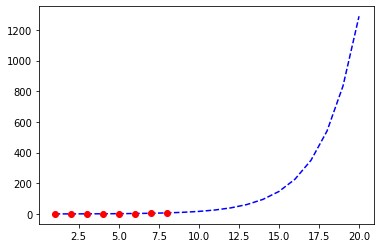

In [125]:
plt.plot(np.linspace(1, 20, 20), expgrowth(np.linspace(1, 20, 20), *popt),"--",color ="blue")

plt.plot(days, subpd[75],'o'  ,color ="red")
